In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Matrix Factorizations from SVD

We can obtain a matrix factorization directly from the review data by using singular value decompositions: all we need to do is specify a rank.

We will use a kfold CV to find the rank.

## Set-up
To begin, we load our data and do our splits.

In [3]:
reviews = pd.read_parquet('../data/clean_columns/reviews_clean_dense.parquet')

In [4]:
from sklearn.model_selection import train_test_split
rev_train, rev_test = train_test_split(reviews,test_size=0.2,random_state=202456,stratify = reviews.AuthorId)

In [5]:
from sklearn.model_selection import StratifiedKFold

n_splits = 4

## Make the kfold object
kfold = StratifiedKFold(n_splits,
                        random_state=202456, 
                        shuffle=True)

We will need to turn each split into an affinity matrix, and keep track of the order of authors/recipes in each matrix.

In [6]:
dfs = {}
for i, (tti, hoi) in enumerate(kfold.split(rev_train, rev_train.AuthorId)):
    rtt = rev_train.iloc[tti].copy()
    rho = rev_train.iloc[hoi].copy()
    dfs[i] = {'Train':rtt,'Holdout':rho}

matrices = {}
userlists_ordered = {}
recipelists = {}
userdics= {}
recipedics = {}
for i in dfs:
    dfi_train = dfs[i]['Train']
    dfi_train['InTraining'] = 1
    mat_df_train = pd.pivot_table(data=dfi_train,index='AuthorId',columns='RecipeId',values='InTraining',fill_value = 0)
    user_ids_ordered = list(mat_df_train.index)
    recipe_ids_ordered = list(mat_df_train.columns)
    userlists_ordered[i] = user_ids_ordered
    recipelists[i] = recipe_ids_ordered
    userdics[i] = {user_ids_ordered[i]:i for i in range(len(user_ids_ordered))}
    recipedics[i] = {recipe_ids_ordered[i]:i for i in range(len(recipe_ids_ordered))}
    matrices[i] = mat_df_train.values

holdout_matrices = {}

for i in range(4):
    user_to_inds = userdics[i]
    recipe_to_inds = recipedics[i]
    mat_holdout = 0 * matrices[i]
    dfi = dfs[i]['Holdout']
    for review in dfi.index:
        user = dfi['AuthorId'][review]
        recipe = dfi['RecipeId'][review]
        user_index = user_to_inds[user]
        if recipe in recipe_to_inds:
            recipe_index = recipe_to_inds[recipe]
            mat_holdout[user_index][recipe_index] +=1
    holdout_matrices[i] = mat_holdout


When we compute the factorizations, we will need to translate the rows so that they have mean 0. To avoid having to repeat this computation, we store those matrices in a dictionary.

In [13]:
matrices_0meanrows = {i:np.array([r-np.mean(r) for r in matrices[i]])
                      for i in matrices}

## SVD hyperparameter tuning

In [5]:
from sklearn.decomposition import TruncatedSVD

We're going to use the 'TruncatedSVD' tool to obtain a factorization. There are two hyperparameters we will adjust: the number of iterations, and the rank of the factorization. 

We will start with a small set of parameters to get a sense of where we should invest our computing resources.

In [15]:
num_iterations = [5,20]
ranks = [4,8,16,32]

matrix_facs = {}
for n in num_iterations:
    for r in ranks:
        svd = TruncatedSVD(n_components=r,n_iter=n)
        for i in matrices:
            matrix = matrices_0meanrows[i]
            umat = svd.fit_transform(matrix)
            rmat=svd.components_
            matrix_facs[(n,r,i)] = (umat,rmat)
        print('n = '+str(n)+', r = '+str(r)+' finished')
            
            

n = 5, r = 4 finished
n = 5, r = 8 finished
n = 5, r = 16 finished
n = 5, r = 32 finished
n = 20, r = 4 finished
n = 20, r = 8 finished
n = 20, r = 16 finished
n = 20, r = 32 finished


The following function returns a summary of the important information for each pair of parameters $n,r$.

In [28]:
def score(n,r):
    summary = {'mean_train':[],
               'mean_holdout':[],
               'global_mean':[],
               'holdout_norm':[],
               'global_mean_norm':[]}
    for i in range(4):
        U,R = matrix_facs[(n,r,i)]
        mat_approx = np.matmul(U,R)
        mean_train = sum([sum(r) for r in (mat_approx*matrices[i])])/len(dfs[i]['Train'])
        mean_holdout = sum([sum(r) for r in (mat_approx*holdout_matrices[i])])/len(dfs[i]['Holdout'])
        global_mean = np.mean([np.mean(r) for r in mat_approx])
        summary['mean_train'].append(mean_train)
        summary['mean_holdout'].append(mean_holdout)
        summary['global_mean'].append(global_mean)
        summary['holdout_norm'].append(mean_holdout/mean_train)
        summary['global_mean_norm'].append(global_mean/mean_train)
    for cat in summary:
        summary[cat] = np.mean(summary[cat])
    return summary

In [31]:
data = {'parameters':[],'mean_train':[],'mean_holdout':[],'global_mean':[],
        'holdout_norm':[],'global_mean_norm':[]}

for n in num_iterations:
    for r in ranks:
        summary = score(n,r)
        data['parameters'].append((n,r))
        for cat in summary:
            data[cat].append(summary[cat])
        print('n = '+str(n)+', r = '+str(r)+' summarized')

n = 5, r = 4 summarized
n = 5, r = 8 summarized
n = 5, r = 16 summarized
n = 5, r = 32 summarized
n = 20, r = 4 summarized
n = 20, r = 8 summarized
n = 20, r = 16 summarized
n = 20, r = 32 summarized


In [34]:
summaries = pd.DataFrame(data=data)
summaries.set_index('parameters',inplace=True)

In [35]:
summaries

,mean_train,mean_holdout,global_mean,holdout_norm,global_mean_norm
parameters,,,,,
"(5, 4)",0.021738,0.009860,7.556346e-22,0.453581,4.092739e-20
"(5, 8)",0.033104,0.009245,6.983127e-21,0.279263,2.145394e-19
"(5, 16)",0.052434,0.008597,-2.160812e-22,0.163950,-4.672367e-21
"(5, 32)",0.083046,0.007634,6.654104e-21,0.091929,7.857791e-20
"(20, 4)",0.021777,0.009822,2.250509e-22,0.451016,8.763513e-21
"(20, 8)",0.033273,0.009261,-7.404996e-20,0.278352,-2.230325e-18
"(20, 16)",0.052870,0.008693,-6.409499e-21,0.164413,-1.212418e-19
"(20, 32)",0.083961,0.007582,-2.232477e-20,0.090307,-2.651777e-19


It looks like we do significantly better when the rank is low. Increasing the number of iterations doesn't appear to help, so we will keep the number of iterations at 5 and do a second batch of testing where we only vary the rank.

In [38]:
n = 5
ranks = [r for r in range(2,12)]

matrix_facs_by_rank = {}
for r in ranks:
    svd = TruncatedSVD(n_components=r,n_iter=n)
    for i in matrices:
        matrix = matrices_0meanrows[i]
        umat = svd.fit_transform(matrix)
        rmat=svd.components_
        matrix_facs[(n,r,i)] = (umat,rmat)
    print('rank = '+str(r)+' finished')
            
            

rank = 2 finished
rank = 3 finished
rank = 4 finished
rank = 5 finished
rank = 6 finished
rank = 7 finished
rank = 8 finished
rank = 9 finished
rank = 10 finished
rank = 11 finished


In [40]:
data2 = {'rank':[],'mean_train':[],'mean_holdout':[],'global_mean':[],
        'holdout_norm':[],'global_mean_norm':[]}

n = 5
for r in ranks:
    summary = score(n,r)
    data2['rank'].append(r)
    for cat in summary:
        data2[cat].append(summary[cat])
    print('rank r = '+str(r)+' summarized')

summaries2 = pd.DataFrame(data=data2)
summaries2.set_index('rank',inplace=True)

rank r = 2 summarized
rank r = 3 summarized
rank r = 4 summarized
rank r = 5 summarized
rank r = 6 summarized
rank r = 7 summarized
rank r = 8 summarized
rank r = 9 summarized
rank r = 10 summarized
rank r = 11 summarized


In [41]:
summaries2

,mean_train,mean_holdout,global_mean,holdout_norm,global_mean_norm
rank,,,,,
2,0.014645,0.010408,-4.860716e-20,0.710705,-3.310218e-18
3,0.018501,0.010120,1.040355e-20,0.547055,5.513498e-19
4,0.021738,0.009771,9.283791e-21,0.449466,4.255885e-19
5,0.024862,0.009481,1.432915e-20,0.381349,5.752802e-19
6,0.027635,0.009417,3.327774e-20,0.340780,1.204686e-18
7,0.030425,0.009374,-2.056244e-20,0.308106,-6.754354e-19
8,0.033107,0.009279,1.333833e-20,0.280270,4.025914e-19
9,0.035729,0.009122,-4.764648e-20,0.255306,-1.337654e-18
10,0.038312,0.008909,4.377792e-20,0.232537,1.142063e-18


Surprisingly, the models with the smallest ranks perform best.

## Final score 
We use our whole training set and compute the score for the $r = 2$ model.

In [7]:
rev_train['InTraining'] = 1
mat_df_train = pd.pivot_table(data=rev_train,index='AuthorId',columns='RecipeId',values='InTraining',fill_value = 0)
user_ids_ordered = list(mat_df_train.index)
recipe_ids_ordered = list(mat_df_train.columns)
mat_train = mat_df_train.values
user_to_inds = {user_ids_ordered[i]:i for i in range(len(user_ids_ordered))}
recipe_to_inds = {recipe_ids_ordered[i]:i for i in range(len(recipe_ids_ordered))}
mat_holdout = 0 * mat_train
for review in rev_test.index:
    user = rev_test['AuthorId'][review]
    recipe = rev_test['RecipeId'][review]
    user_index = user_to_inds[user]
    recipe_index = recipe_to_inds[recipe]
    mat_holdout[user_index][recipe_index] +=1

In [8]:
mat_train_mean0 = [r - np.mean(r) for r in mat_train]
svd = TruncatedSVD(n_components=2,n_iter=5)
umat = svd.fit_transform(mat_train_mean0)
rmat = svd.components_
mat_approx = np.matmul(umat,rmat)
mean_train = sum([sum(r) for r in (mat_approx*mat_train)])/len(rev_train)
mean_holdout = sum([sum(r) for r in (mat_approx*mat_holdout)])/len(rev_test)
global_mean = np.mean([np.mean(r) for r in mat_approx])
holdout_norm = mean_holdout/mean_train
global_norm = global_mean/mean_train
print('Normalized test mean:'+str(holdout_norm))
print('Normalized global mean:'+str(global_norm))

Normalized test mean:0.8028411103761666
Normalized global mean:4.84123336078485e-18


## Exploring final model

In [ ]:
rev_train['InTraining'] = 1
mat_df_train = pd.pivot_table(data=rev_train,index='AuthorId',columns='RecipeId',values='InTraining',fill_value = 0)
user_ids_ordered = list(mat_df_train.index)
recipe_ids_ordered = list(mat_df_train.columns)
user_id_to_index = {user_ids_ordered[i]:i for i in range(len(user_ids_ordered))}
recipe_id_to_index = {recipe_ids_ordered[i]:i for i in range(len(recipe_ids_ordered))}
mat_train = mat_df_train.values

holdout_matrix = 0*mat_train

for review in rev_test.index:
    user = rev_test['AuthorId'][review]
    recipe = rev_test['RecipeId'][review]
    holdout_matrix[user_id_to_index[user]][recipe_id_to_index[recipe]]+=1


In [10]:
svd = TruncatedSVD(n_components=2)
umat = svd.fit_transform([r-np.mean(r) for r in mat_train])
rmat=svd.components_

In [13]:
recipe_names = pd.read_parquet('../data/clean_columns/RCnames.parquet')
recipe_names['SVDvec'] = [np.transpose(rmat)[recipe_id_to_index[rec_id]]
                          for rec_id in recipe_names.index]
mean_length = recipe_names['SVDvec'].apply(lambda x:np.linalg.norm(x)).mean()
recipe_names['SVDvec_norm'] = recipe_names.SVDvec/mean_length
recipe_names = recipe_names[['Name','SVDvec_norm']]

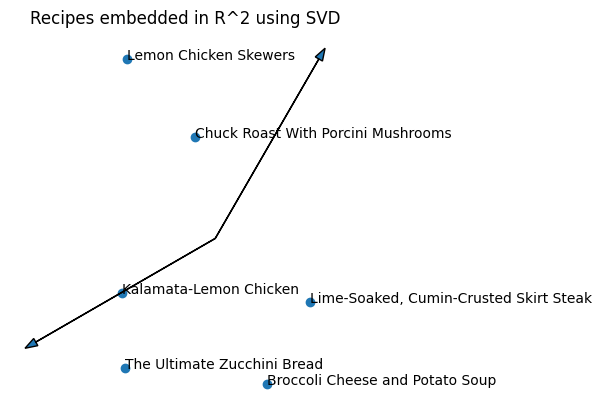

In [65]:
df0 = recipe_names.sample(6,random_state=3)
pts = df0.SVDvec_norm.values
xs = np.transpose(list(pts))[0]
ys = np.transpose(list(pts))[1]
names = list(df0.Name)

fig,ax = plt.subplots()
ax.scatter(xs,ys)
for i, txt in enumerate(names):
    ax.annotate(txt, (xs[i], ys[i]))

plt.arrow(x=0,y=0,dx = 0.5,dy=np.sqrt(3/4),head_width = 0.04)
plt.arrow(x=0,y=0,dx = -np.sqrt(3/4),dy=-0.5,head_width = 0.04)
ax.axis('off')
plt.gca().set_aspect('equal')
plt.title('Recipes embedded in R^2 using SVD',loc='right')
plt.show()